In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Fetch historical data for Reliance Industries
df = yf.download('RELIANCE.NS', start='2010-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


Strategy 1: Trend Reversal Confirmation

Trend Indicator: Moving Average Convergence Divergence (MACD)

Momentum Indicator: Relative Strength Index (RSI)

Volatility Indicator: Bollinger Bands

Volume Indicator: On-Balance Volume (OBV)

Strategy:

Buy Signal: When the price crosses below the lower Bollinger Band, and MACD crosses above the signal line, and RSI is below 25, and OBV is rising.

Sell Signal: When the price crosses above the upper Bollinger Band, and MACD crosses below the signal line, and RSI is above 75, and OBV is rising.

Number of Trades: 73
Average Return per Trade: 6.78%
Win Rate: 86.30%
Risk to Reward Ratio: 4.28
Maximum Drawdown Ratio: -3.58%
Sharpe Ratio: 0.77


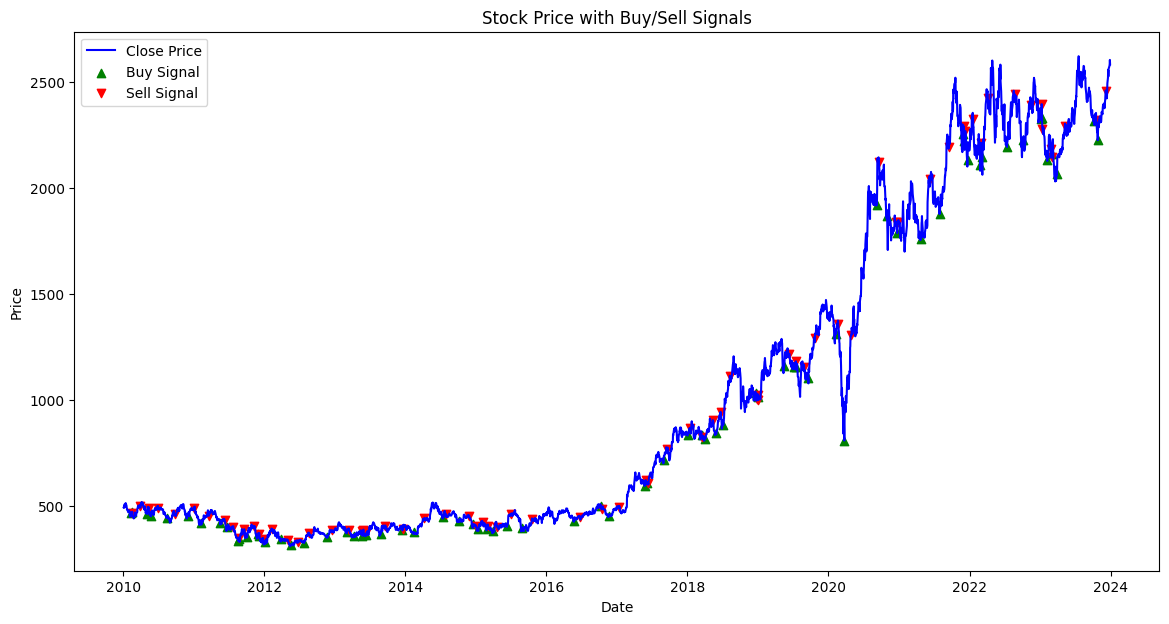

In [ ]:
# Define functions for indicators
def calculate_MACD(df, n_fast=12, n_slow=26, n_signal=9):
    """
    Function to calculate MACD and Signal Line
    """
    EMA_fast = df['Close'].ewm(span=n_fast, min_periods=1).mean()
    EMA_slow = df['Close'].ewm(span=n_slow, min_periods=1).mean()
    MACD = EMA_fast - EMA_slow
    Signal = MACD.ewm(span=n_signal, min_periods=1).mean()
    return MACD, Signal

def calculate_RSI(df, n=20):
    """
    Function to calculate RSI
    """
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=n, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=n, min_periods=1).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def calculate_Bollinger_Bands(df, n=20):
    """
    Function to calculate Bollinger Bands
    """
    MA = df['Close'].rolling(window=n, min_periods=1).mean()
    std = df['Close'].rolling(window=n, min_periods=1).std()
    upper_band = MA + 1 * std
    lower_band = MA - 1 * std
    return upper_band, lower_band

def calculate_OBV(df):
    """
    Function to calculate On-Balance Volume (OBV)
    """
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    return df['OBV']

# Define function for trading strategy
def apply_strategy(df):
    """
    Function to apply the trading strategy
    """
    df['MACD'], df['Signal'] = calculate_MACD(df)
    df['RSI'] = calculate_RSI(df)
    df['UpperBand'], df['LowerBand'] = calculate_Bollinger_Bands(df)
    df['OBV'] = calculate_OBV(df)


    buy_conditions = (
      # Price Breakout
      ((df['Close'] < df['LowerBand']) | (df['Close'].shift(-1) < df['LowerBand'].shift(-1)) | (df['Close'].shift(1) < df['LowerBand'].shift(1))) &
      # MACD Crossover Confirmation(MACD cutting SIGNAL from below)
      ((df['MACD'].shift(1) < df['Signal'].shift(1)) & (df['MACD'].shift(-1) > df['Signal'].shift(-1)) |
       (df['MACD'].shift(2) < df['Signal'].shift(2)) & (df['MACD'] > df['Signal']) |
        (df['MACD'] < df['Signal']) & (df['MACD'].shift(-2) > df['Signal'].shift(-2)) |
         (df['MACD'].shift(3) < df['Signal'].shift(3)) & (df['MACD'].shift(1) > df['Signal'].shift(1)) |
          (df['MACD'].shift(-1) < df['Signal'].shift(-1)) & (df['MACD'].shift(-3) > df['Signal'].shift(-3))) |
      # RSI Oversold(and decreasing)
      ((df['RSI'] < 25) & (df['RSI'].shift(1) >= 25) |
       (df['RSI'].shift(-1) < 25) & (df['RSI'] >= 25) |
        (df['RSI'].shift(2) < 25) & (df['RSI'].shift(1) >= 25) |
         (df['RSI'].shift(-2) < 25) & (df['RSI'].shift(-1) >= 25)) &
      # OBV Confirmation(increasing)
      ((df['OBV'].shift(-1) > df['OBV']) & (df['OBV'] > df['OBV'].shift(1)))
    )

    sell_conditions = (
      # Price Breakdown
      ((df['Close'] > df['UpperBand']) | (df['Close'].shift(-1) > df['LowerBand'].shift(-1)) | (df['Close'].shift(1) > df['LowerBand'].shift(1))) &
      # MACD Divergence Confirmation(MACD cutting SIGNAL from above)
      ((df['MACD'].shift(1) > df['Signal'].shift(1)) & (df['MACD'].shift(-1) < df['Signal'].shift(-1)) |
       (df['MACD'].shift(2) > df['Signal'].shift(2)) & (df['MACD'] < df['Signal']) |
        (df['MACD'] > df['Signal']) & (df['MACD'].shift(-2) < df['Signal'].shift(-2)) |
         (df['MACD'].shift(3) > df['Signal'].shift(3)) & (df['MACD'].shift(1) < df['Signal'].shift(1)) |
          (df['MACD'].shift(-1) > df['Signal'].shift(-1)) & (df['MACD'].shift(-3) < df['Signal'].shift(-3))) |
      # RSI Overbought(and increasing)
      ((df['RSI'] > 75) & (df['RSI'].shift(1) <= 75) |
       (df['RSI'].shift(-1) > 75) & (df['RSI'] <= 75) |
        (df['RSI'].shift(2) > 75) & (df['RSI'].shift(1) <= 75) |
         (df['RSI'].shift(-2) > 75) & (df['RSI'].shift(-1) <= 75)) &
      # OBV Confirmation(decreasing)
      ((df['OBV'].shift(-1) < df['OBV']) & (df['OBV'] < df['OBV'].shift(1)))
    )

    df['Buy Signal'] = buy_conditions
    df['Sell Signal'] = sell_conditions

    return df

# Define function to simulate trades
def simulate_trades(df):
  """
  Function to simulate trades based on strategy
  """
  trades = []
  position = None
  entry_price = None
  entry_date = None

  for index, row in df.iterrows():
    if row['Buy Signal']:
      if position != 'buy':
        position = 'buy'
        entry_price = row['Close']
        entry_date = index

    elif row['Sell Signal']:
      if position == 'buy':
        # Early exit for stop-loss
        if entry_price is not None and row['Close'] < entry_price * (1 - 0.04) and position == 'buy':
          exit_price = row['Close']
          exit_date = index
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None
        else:
          exit_date = index
          exit_price = row['Close']
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None

  trades_df = pd.DataFrame(trades)
  return trades_df

# Apply the strategy
df = apply_strategy(df)

# Simulate trades
trades_df = simulate_trades(df)

# Calculate performance metrics:
num_trades = len(trades_df)
average_return_per_trade = trades_df['PnL (%)'].mean()
win_rate = (trades_df['PnL (%)'] > 0).sum() / len(trades_df) * 100
risk_to_reward_ratio = abs(trades_df[trades_df['PnL (%)'] > 0]['PnL (%)'].mean() / trades_df[trades_df['PnL (%)'] < 0]['PnL (%)'].mean())
maximum_drawdown_ratio = trades_df['PnL (%)'].min()
sharpe_ratio = trades_df['PnL (%)'].mean() / trades_df['PnL (%)'].std()

# Print performance metrics
print("Number of Trades:", num_trades)
print("Average Return per Trade: {:.2f}%".format(average_return_per_trade))
print("Win Rate: {:.2f}%".format(win_rate))
print("Risk to Reward Ratio: {:.2f}".format(risk_to_reward_ratio))
print("Maximum Drawdown Ratio: {:.2f}%".format(maximum_drawdown_ratio))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

# Plot trades on a graph with stock price
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.scatter(trades_df['Entry Date'], trades_df['Entry Price'], marker='^', color='green', label='Buy Signal')
plt.scatter(trades_df['Exit Date'], trades_df['Exit Price'], marker='v', color='red', label='Sell Signal')
plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
trades_df

,Entry Date,Exit Date,Entry Price,Exit Price,PnL (%)
0,2010-02-11,2010-02-16,464.092438,465.281067,0.256119
1,2010-02-17,2010-03-29,472.047119,499.819977,5.883493
2,2010-05-06,2010-05-13,460.755127,489.990906,6.345188
3,2010-05-25,2010-07-02,450.606018,488.687988,8.451279
4,2010-08-18,2010-09-27,440.982666,461.829468,4.727352
...,...,...,...,...,...
68,2023-02-06,2023-02-27,2133.467529,2185.524658,2.440024
69,2023-03-01,2023-03-02,2163.418945,2146.943359,-0.761553
70,2023-03-27,2023-05-12,2065.257812,2293.054199,11.029925
71,2023-10-06,2023-10-18,2318.000000,2324.000000,0.258844


Strategy 2: Breakout Confirmation

Trend Indicator: Average Directional Index (ADX)

Momentum Indicator: Stochastic Oscillator

Volatility Indicator: Average True Range (ATR)

Volume Indicator: Chaikin Money Flow (CMF)

Strategy:

Buy Signal: When ADX indicates a strong trend, Stochastic Oscillator crosses above 75, ATR shows high volatility, and CMF is positive and increasing.

Sell Signal: When ADX indicates a strong trend, Stochastic Oscillator crosses below 25, ATR shows high volatility, and CMF is negative and decreasing.

Number of Trades: 31
Average Return per Trade: 5.33%
Win Rate: 64.52%
Risk to Reward Ratio: 2.39
Maximum Drawdown Ratio: -6.56%
Sharpe Ratio: 0.52


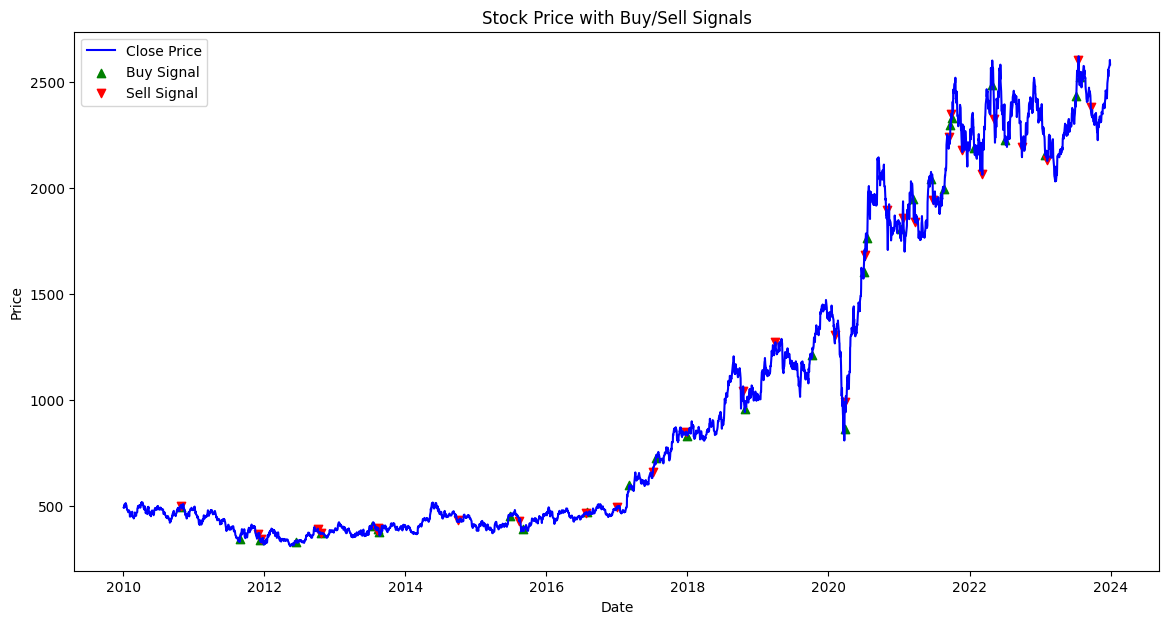

In [ ]:
# Define functions for indicators
def calculate_ADX(df, n=20):
    """
    Function to calculate Average Directional Index (ADX)
    """
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())

    high_low = high_low.rolling(window=n, min_periods=1).mean()
    high_close = high_close.rolling(window=n, min_periods=1).mean()
    low_close = low_close.rolling(window=n, min_periods=1).mean()

    TR = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    plus_DM = np.where((df['High'] - df['High'].shift()) > (df['Low'].shift() - df['Low']),
                       np.maximum(df['High'] - df['High'].shift(), 0), 0)
    minus_DM = np.where((df['Low'].shift() - df['Low']) > (df['High'] - df['High'].shift()),
                        np.maximum(df['Low'].shift() - df['Low'], 0), 0)

    plus_DM = pd.Series(plus_DM, index=df.index)
    minus_DM = pd.Series(minus_DM, index=df.index)

    ATR = TR.ewm(span=n, min_periods=1).mean()
    plus_DI = (plus_DM / ATR).ewm(span=n, min_periods=1).mean() * 100
    minus_DI = (minus_DM / ATR).ewm(span=n, min_periods=1).mean() * 100

    DX = (np.abs(plus_DI - minus_DI) / (plus_DI + minus_DI)).ewm(span=n, min_periods=1).mean() * 100
    ADX = DX.ewm(span=n, min_periods=1).mean()

    return ADX

def calculate_Stochastic_Oscillator(df, n=20):
    """
    Function to calculate Stochastic Oscillator
    """
    low_min = df['Low'].rolling(window=n, min_periods=1).min()
    high_max = df['High'].rolling(window=n, min_periods=1).max()

    K = ((df['Close'] - low_min) / (high_max - low_min)) * 100
    return K

def calculate_Stochastic_Oscillator_D(df, n=10):
    """
    Function to calculate Stochastic Oscillator %D
    """
    K = calculate_Stochastic_Oscillator(df)
    D = K.rolling(window=n, min_periods=1).mean()
    return D


def calculate_ATR(df, n=20):
    """
    Function to calculate Average True Range (ATR)
    """
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())

    TR = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    ATR = TR.rolling(window=n, min_periods=1).mean()
    return ATR

def calculate_CMF(df, n=10):
    """
    Function to calculate Chaikin Money Flow (CMF)
    """
    MF_mult = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    MF_vol = MF_mult * df['Volume']

    CMF = MF_vol.rolling(window=n, min_periods=1).sum() / df['Volume'].rolling(window=n, min_periods=1).sum()
    return CMF

# Define function for trading strategy
def apply_strategy_2(df):
    """
    Function to apply the trading strategy
    """
    df['ADX'] = calculate_ADX(df)
    df['Stochastic_Oscillator'] = calculate_Stochastic_Oscillator(df)
    df['ATR'] = calculate_ATR(df)
    df['CMF'] = calculate_CMF(df)
    df['Stochastic_Oscillator_D'] = calculate_Stochastic_Oscillator_D(df)

    shifted_high = df['Stochastic_Oscillator'].shift(1)  # Shift values up one period
    shifted_low = df['Stochastic_Oscillator'].shift(-1) # Shift values down one period

    buy_conditions = (
        # ADX indicates a strong trend
        ((df['ADX'] > 20) & (df['ADX'].shift(-1) > 20) & (df['ADX'].shift(1) > 20) &
         (df['ADX'].shift(2) < df['ADX'].shift(1)) & (df['ADX'].shift(1) < df['ADX']) & (df['ADX'] < df['ADX'].shift(-1))) &
        # Stochastic Oscillator crosses above 70
        (((df['Stochastic_Oscillator'] > 75) & (shifted_high <= 75)) |
         ((shifted_low > 75) & (df['Stochastic_Oscillator'] <= 75)) |
         (df['Stochastic_Oscillator_D'] > df['Stochastic_Oscillator']) |
          (df['Stochastic_Oscillator_D'].shift(1) > df['Stochastic_Oscillator'].shift(1)) |
           (df['Stochastic_Oscillator_D'].shift(2) > df['Stochastic_Oscillator'].shift(2))) &
        # ATR shows high volatility
        ((df['ATR'] > df['ATR'].rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(1) > df['ATR'].shift(1).rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(-1) > df['ATR'].shift(-1).rolling(window=20, min_periods=1).mean())) &
        # CMF is positive and increasing
        ((df['CMF'] > -0.13) & (df['CMF'].shift(2) > df['CMF'].shift(1)) & (df['CMF'].shift(1) < df['CMF']))
    )

    sell_conditions = (
        # ADX indicates a strong trend
        ((df['ADX'] > 20) & (df['ADX'].shift(-1) > 20) & (df['ADX'].shift(1) > 20) &
         (df['ADX'].shift(2) < df['ADX'].shift(1)) & (df['ADX'].shift(1) < df['ADX']) & (df['ADX'] < df['ADX'].shift(-1))) &
        # Stochastic Oscillator crosses below 20
        (((df['Stochastic_Oscillator'] < 25) & (shifted_high >= 25)) |
         ((shifted_low < 25) & (df['Stochastic_Oscillator'] >= 25)) |
         (df['Stochastic_Oscillator_D'] < df['Stochastic_Oscillator']) |
          (df['Stochastic_Oscillator_D'].shift(1) < df['Stochastic_Oscillator'].shift(1)) |
           (df['Stochastic_Oscillator_D'].shift(2) < df['Stochastic_Oscillator'].shift(2))) &
        # ATR shows high volatility
        ((df['ATR'] > df['ATR'].rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(1) > df['ATR'].shift(1).rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(-1) > df['ATR'].shift(-1).rolling(window=20, min_periods=1).mean())) &
        # CMF is negative and decreasing
        ((df['CMF'] < 0.13) & (df['CMF'].shift(2) < df['CMF'].shift(1)) & (df['CMF'].shift(1) < df['CMF']))
    )

    df['Buy Signal'] = buy_conditions
    df['Sell Signal'] = sell_conditions

    return df

# Define function to simulate trades
def simulate_trades_2(df):
    """
    Function to simulate trades based on strategy
    """
    trades = []
    position = None
    entry_price = None
    entry_date = None

    for index, row in df.iterrows():
     if row['Buy Signal']:
      if position != 'buy':
        position = 'buy'
        entry_price = row['Close']
        entry_date = index

     # Early exit for stop-loss
     if entry_price is not None and row['Close'] < entry_price * (1 - 0.05) and position == 'buy':
          exit_price = row['Close']
          exit_date = index
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None

     elif row['Sell Signal']:
      if position == 'buy':
          exit_date = index
          exit_price = row['Close']
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None

    trades_df = pd.DataFrame(trades)
    return trades_df

# Apply the strategy
df = apply_strategy_2(df)

# Simulate trades
trades_df = simulate_trades_2(df)

# Calculate performance metrics:
num_trades = len(trades_df)
average_return_per_trade = trades_df['PnL (%)'].mean()
win_rate = (trades_df['PnL (%)'] > 0).sum() / len(trades_df) * 100
risk_to_reward_ratio = abs(trades_df[trades_df['PnL (%)'] > 0]['PnL (%)'].mean() / trades_df[trades_df['PnL (%)'] < 0]['PnL (%)'].mean())
maximum_drawdown_ratio = trades_df['PnL (%)'].min()
sharpe_ratio = trades_df['PnL (%)'].mean() / trades_df['PnL (%)'].std()

# Print performance metrics
print("Number of Trades:", num_trades)
print("Average Return per Trade: {:.2f}%".format(average_return_per_trade))
print("Win Rate: {:.2f}%".format(win_rate))
print("Risk to Reward Ratio: {:.2f}".format(risk_to_reward_ratio))
print("Maximum Drawdown Ratio: {:.2f}%".format(maximum_drawdown_ratio))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

# Plot trades on a graph with stock price
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.scatter(trades_df['Entry Date'], trades_df['Entry Price'], marker='^', color='green', label='Buy Signal')
plt.scatter(trades_df['Exit Date'], trades_df['Exit Price'], marker='v', color='red', label='Sell Signal')
plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
trades_df

,Entry Date,Exit Date,Entry Price,Exit Price,PnL (%)
0,2010-10-28,2010-10-29,494.653992,501.168610,1.317005
1,2011-08-29,2011-12-01,345.183472,365.275909,5.820799
2,2011-12-13,2011-12-15,339.354584,342.943329,1.057521
3,2012-06-14,2012-10-05,327.491119,392.157288,19.745930
4,2012-10-22,2012-10-23,372.864868,370.281891,-0.692738
5,2013-07-12,2013-08-06,406.855194,384.499756,-5.494692
6,2013-08-13,2013-08-14,389.917175,395.448914,1.418696
7,2013-08-19,2014-09-30,374.990692,432.342224,15.294121
8,2015-06-29,2015-08-13,452.983276,426.696228,-5.803095
9,2015-09-03,2016-07-22,390.351501,463.955292,18.855772


Strategy 3: Trend Continuation

Trend Indicator: Ichimoku Cloud

Momentum Indicator: Moving Average Convergence Divergence (MACD)

Volatility Indicator: Average True Range (ATR)

Strategy:

Buy Signal: When the price is above the cloud, MACD bullish crossover happens, ATR shows increasing volatility.

Sell Signal: When the price is below the cloud, MACD bearish bearish crossover happens, ATR shows increasing volatility.

Number of Trades: 42
Average Return per Trade: 6.35%
Win Rate: 64.29%
Risk to Reward Ratio: 2.13
Maximum Drawdown Ratio: -8.03%
Sharpe Ratio: 0.51


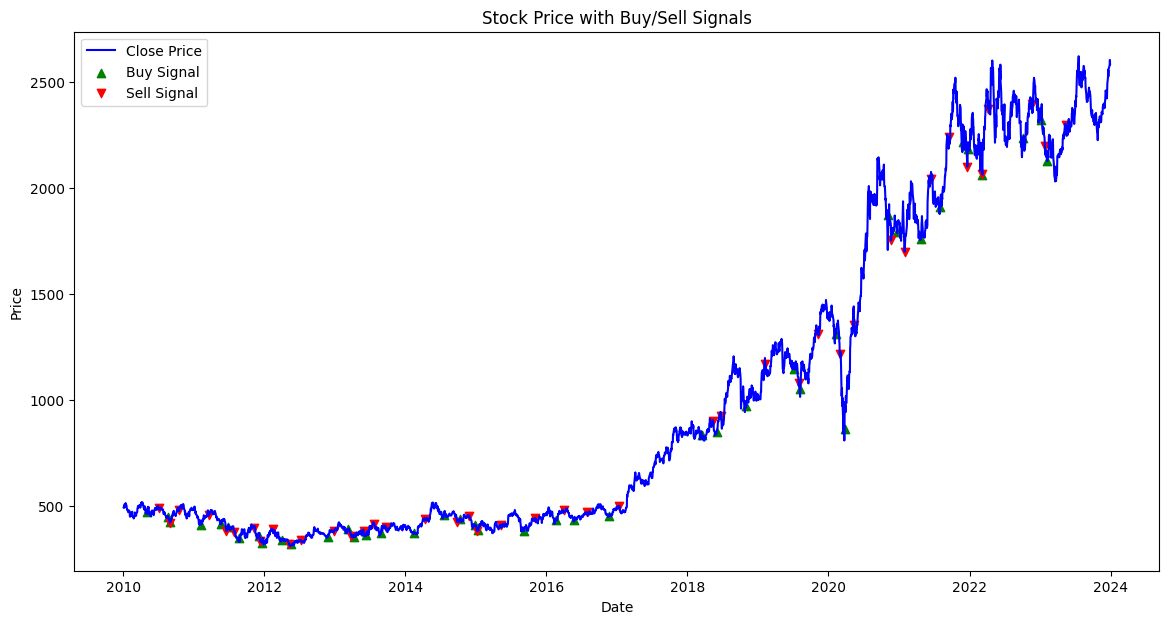

In [ ]:
# Define function to calculate Ichimoku Cloud
def calculate_ichimoku_cloud(df):
    """
    Function to calculate Ichimoku Cloud
    """
    conversion_line_period = 9
    base_line_period = 26
    leading_span_b_period = 52
    displacement = 26

    # Tenkan-sen (Conversion Line)
    df['Tenkan_sen'] = (df['High'].rolling(window=conversion_line_period).max() + df['Low'].rolling(window=conversion_line_period).min()) / 2

    # Kijun-sen (Base Line)
    df['Kijun_sen'] = (df['High'].rolling(window=base_line_period).max() + df['Low'].rolling(window=base_line_period).min()) / 2

    # Senkou Span A (Leading Span A)
    df['Senkou_Span_A'] = ((df['Tenkan_sen'] + df['Kijun_sen']) / 2).shift(displacement)

    # Senkou Span B (Leading Span B)
    df['Senkou_Span_B'] = ((df['High'].rolling(window=leading_span_b_period).max() + df['Low'].rolling(window=leading_span_b_period).min()) / 2).shift(displacement)

    return df

# Define function to calculate MACD
def calculate_MACD(df, n_fast=12, n_slow=26, n_signal=9):
    """
    Function to calculate MACD and Signal Line
    """
    EMA_fast = df['Close'].ewm(span=n_fast, min_periods=1).mean()
    EMA_slow = df['Close'].ewm(span=n_slow, min_periods=1).mean()
    MACD = EMA_fast - EMA_slow
    Signal = MACD.ewm(span=n_signal, min_periods=1).mean()
    return MACD, Signal

# Define function to calculate ATR
def calculate_ATR(df, n=10):
    """
    Function to calculate Average True Range (ATR)
    """
    high_low = df['High'] - df['Low']
    high_close = (df['High'] - df['Close'].shift()).abs()
    low_close = (df['Low'] - df['Close'].shift()).abs()
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    ATR = true_range.rolling(window=n, min_periods=1).mean()
    return ATR

# Define function to calculate VWAP
def calculate_VWAP(df):
    """
    Function to calculate Volume Weighted Average Price (VWAP)
    """
    df['VWAP'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()
    return df['VWAP']

# Define function for trading strategy
def apply_combination_strategy(df):
    """
    Function to apply the combination trading strategy
    """
    df = calculate_ichimoku_cloud(df)
    df['VWAP'] = calculate_VWAP(df)
    df['MACD'] , df['Signal'] = calculate_MACD(df)

    buy_conditions = (
        # Price is above the Cloud
        ((df['Close'] < df['Senkou_Span_A']) & (df['Close'] < df['Senkou_Span_B'])) &
        # MACD Crossover Confirmation(MACD cutting SIGNAL from below)
        ((df['MACD'].shift(1) < df['Signal'].shift(1)) & (df['MACD'].shift(-1) > df['Signal'].shift(-1)) |
         (df['MACD'].shift(2) < df['Signal'].shift(2)) & (df['MACD'] > df['Signal']) |
          (df['MACD'] < df['Signal']) & (df['MACD'].shift(-2) > df['Signal'].shift(-2)) |
           (df['MACD'].shift(3) < df['Signal'].shift(3)) & (df['MACD'].shift(1) > df['Signal'].shift(1))) &
        # ATR shows high volatility
        ((df['ATR'] > df['ATR'].rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(1) > df['ATR'].shift(1).rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(2) > df['ATR'].shift(2).rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(-1) > df['ATR'].shift(-1).rolling(window=20, min_periods=1).mean()))
    )

    sell_conditions = (
        # Price is below the Cloud
        ((df['Close'] > df['Senkou_Span_A']) & (df['Close'] > df['Senkou_Span_B']) ) &
        # MACD Divergence Confirmation(MACD cutting SIGNAL from above)
        ((df['MACD'].shift(1) > df['Signal'].shift(1)) & (df['MACD'].shift(-1) < df['Signal'].shift(-1)) |
         (df['MACD'].shift(2) > df['Signal'].shift(2)) & (df['MACD'] < df['Signal']) |
          (df['MACD'] > df['Signal']) & (df['MACD'].shift(-2) < df['Signal'].shift(-2)) |
          (df['MACD'].shift(3) > df['Signal'].shift(3)) & (df['MACD'].shift(1) < df['Signal'].shift(1))) &
        # ATR shows high volatility
        ((df['ATR'] > df['ATR'].rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(1) > df['ATR'].shift(1).rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(2) > df['ATR'].shift(2).rolling(window=20, min_periods=1).mean()) |
         (df['ATR'].shift(-1) > df['ATR'].shift(-1).rolling(window=20, min_periods=1).mean()))
    )

    df['Buy Signal'] = buy_conditions
    df['Sell Signal'] = sell_conditions

    return df

# Define function to simulate trades
def simulate_trades_3(df):
    """
    Function to simulate trades based on strategy
    """
    trades = []
    position = None
    entry_price = None
    entry_date = None

    for index, row in df.iterrows():
     if row['Buy Signal']:
      if position != 'buy':
        position = 'buy'
        entry_price = row['Close']
        entry_date = index

     # Early exit for stop-loss
     if entry_price is not None and row['Close'] < entry_price * (1 - 0.05) and position == 'buy':
          exit_price = row['Close']
          exit_date = index
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None

     elif row['Sell Signal']:
      if position == 'buy':
          exit_date = index
          exit_price = row['Close']
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None

    trades_df = pd.DataFrame(trades)
    return trades_df

# Apply the strategy
df = apply_combination_strategy(df)

# Simulate trades
trades_df = simulate_trades_3(df)

# Calculate performance metrics:
num_trades = len(trades_df)
average_return_per_trade = trades_df['PnL (%)'].mean()
win_rate = (trades_df['PnL (%)'] > 0).sum() / len(trades_df) * 100
risk_to_reward_ratio = abs(trades_df[trades_df['PnL (%)'] > 0]['PnL (%)'].mean() / trades_df[trades_df['PnL (%)'] < 0]['PnL (%)'].mean())
maximum_drawdown_ratio = trades_df['PnL (%)'].min()
sharpe_ratio = trades_df['PnL (%)'].mean() / trades_df['PnL (%)'].std()

# Print performance metrics
print("Number of Trades:", num_trades)
print("Average Return per Trade: {:.2f}%".format(average_return_per_trade))
print("Win Rate: {:.2f}%".format(win_rate))
print("Risk to Reward Ratio: {:.2f}".format(risk_to_reward_ratio))
print("Maximum Drawdown Ratio: {:.2f}%".format(maximum_drawdown_ratio))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

# Plot trades on a graph with stock price
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.scatter(trades_df['Entry Date'], trades_df['Entry Price'], marker='^', color='green', label='Buy Signal')
plt.scatter(trades_df['Exit Date'], trades_df['Exit Price'], marker='v', color='red', label='Sell Signal')
plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
trades_df

,Entry Date,Exit Date,Entry Price,Exit Price,PnL (%)
0,2010-05-07,2010-07-06,472.161407,490.950958,3.979476
1,2010-08-19,2010-08-31,446.742950,420.227325,-5.935320
2,2010-09-03,2010-10-18,423.198883,478.858887,13.152209
3,2011-02-10,2011-03-22,411.289703,457.006348,11.115436
4,2011-05-25,2011-06-20,414.192719,380.933868,-8.029801
5,2011-06-27,2011-07-29,398.443329,378.510895,-5.002577
6,2011-08-22,2011-11-09,346.074921,395.426056,14.260246
7,2011-12-08,2011-12-12,356.064026,332.588531,-6.593054
8,2011-12-20,2012-02-14,326.165344,388.088531,18.985214
9,2012-04-02,2012-05-09,338.554535,317.776337,-6.137327


Strategy 4: Momentum Breakout

Trend Indicator: Parabolic SAR

Momentum Indicator: Relative Strength Index (RSI)

Volatility Indicator: Keltner Channels

Volume Indicator: Money Flow Index (MFI)

Strategy:

Buy Signal: When Parabolic SAR flips below the price, RSI crosses above 80, price closes above the upper Keltner Channel, and MFI is rising.

Sell Signal: When Parabolic SAR flips above the price, RSI crosses below 20, price closes below the lower Keltner Channel, and MFI is falling.

Number of Trades: 54
Average Return per Trade: 2.68%
Win Rate: 46.30%
Risk to Reward Ratio: 2.47
Maximum Drawdown Ratio: -6.29%
Sharpe Ratio: 0.20


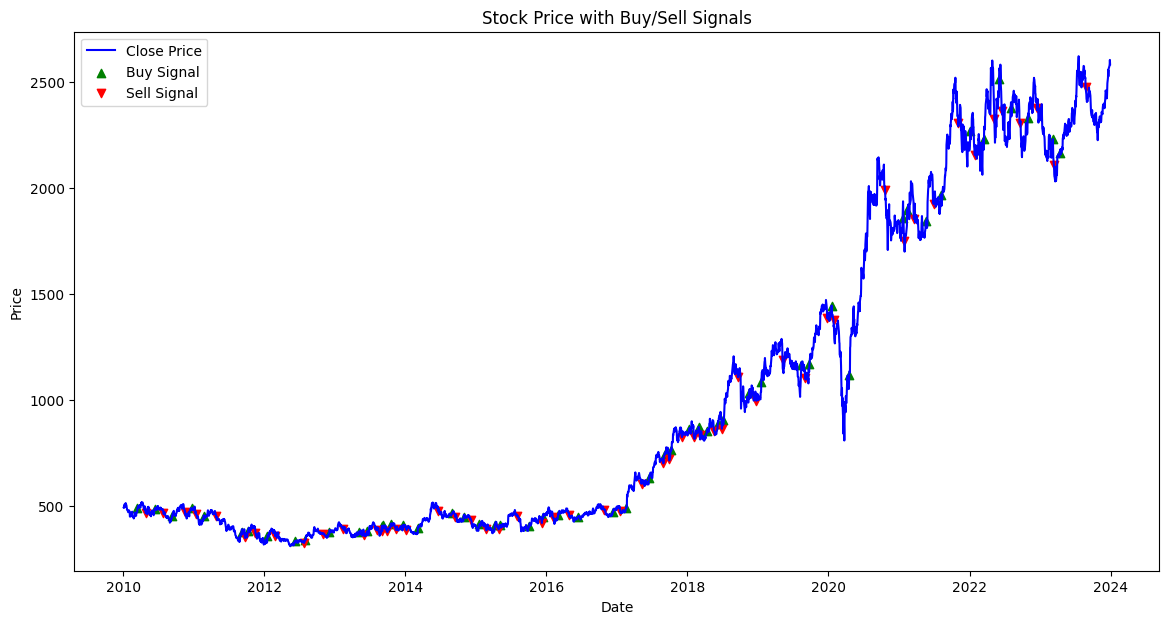

In [ ]:
# Define function to calculate Parabolic SAR
def calculate_parabolic_sar(df, acceleration=0.02, max_acceleration=0.2):
    """
    Function to calculate Parabolic SAR
    """
    sar = df['High'].iloc[0]
    af = acceleration
    ep = df['Low'].iloc[0]
    long_positions = []
    short_positions = []

    for i in range(len(df)):
        if df['Close'].iloc[i - 1] < sar:
            af = min(af + acceleration, max_acceleration)
        else:
            af = acceleration

        if df['High'].iloc[i] > ep:
            sar = sar + af * (ep - sar)
            ep = df['High'].iloc[i]
            af = min(af + acceleration, max_acceleration)
        else:
            sar = sar + af * (ep - sar)

        long_positions.append(sar)

        if df['Close'].iloc[i - 1] > sar:
            af = min(af + acceleration, max_acceleration)
        else:
            af = acceleration

        if df['Low'].iloc[i] < ep:
            sar = sar + af * (ep - sar)
            ep = df['Low'].iloc[i]
            af = min(af + acceleration, max_acceleration)
        else:
            sar = sar + af * (ep - sar)

        short_positions.append(sar)

    df['Parabolic_SAR'] = short_positions if df['Close'].iloc[-1] < df['Open'].iloc[-1] else long_positions
    return df['Parabolic_SAR']

# Define function to calculate RSI
def calculate_rsi(df, n=14):
    """
    Function to calculate Relative Strength Index (RSI)
    """
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=n, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=n, min_periods=1).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Define function to calculate Keltner Channels
def calculate_keltner_channels(df, n=30, atr_multiplier=1):
    """
    Function to calculate Keltner Channels
    """
    df['ATR'] = df['High'] - df['Low']
    df['Upper_Keltner'] = df['Close'].rolling(window=n).mean() + atr_multiplier * df['ATR'].rolling(window=n).mean()
    df['Lower_Keltner'] = df['Close'].rolling(window=n).mean() - atr_multiplier * df['ATR'].rolling(window=n).mean()
    return df['Upper_Keltner'], df['Lower_Keltner']

# Define function to calculate Money Flow Index (MFI)
def calculate_mfi(df, n=30):
    """
    Function to calculate Money Flow Index (MFI)
    """
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    money_flow = typical_price * df['Volume']
    positive_flow = np.where(typical_price.diff() > 0, money_flow, 0)
    negative_flow = np.where(typical_price.diff() < 0, money_flow, 0)
    positive_mf = np.sum(positive_flow, axis=0)
    negative_mf = np.sum(negative_flow, axis=0)
    money_ratio = positive_mf / negative_mf
    mfi = 100 - (100 / (1 + money_ratio))
    return mfi

# Define function for trading strategy for Momentum Breakout
def apply_momentum_breakout_strategy(df):
    """
    Function to apply the Momentum Breakout trading strategy
    """
    df['Parabolic_SAR'] = calculate_parabolic_sar(df)
    df['RSI'] = calculate_rsi(df)
    upper_keltner, lower_keltner = calculate_keltner_channels(df)
    df['MFI'] = calculate_mfi(df)

    buy_conditions = (
        # Parabolic SAR flips below the price
        ((df['Parabolic_SAR'].shift(1) > df['Close'].shift(1)) & (df['Parabolic_SAR'] < df['Close']) |
         (df['Parabolic_SAR'].shift(2) > df['Close'].shift(2)) & (df['Parabolic_SAR'].shift(1) < df['Close'].shift(1))) &
        # RSI crosses above 80
        ((df['RSI'] > 80) & (df['RSI'].shift(1) > 80)) |
        # Price closes above the upper Keltner Channel
        (df['Close'].shift(1) < upper_keltner.shift(1)) & (df['Close'] > upper_keltner) | (df['Close'] < 0.5*upper_keltner) &
        # MFI is rising
        ((df['MFI'].shift(1) < df['MFI']) & (df['MFI'].shift(2) < df['MFI'].shift(1)) & (df['MFI'].shift(3) < df['MFI'].shift(2)))
    )

    sell_conditions = (
        # Parabolic SAR flips above the price
        ((df['Parabolic_SAR'].shift(1) < df['Close'].shift(1)) & (df['Parabolic_SAR'] > df['Close']) |
         (df['Parabolic_SAR'].shift(2) < df['Close'].shift(2)) & (df['Parabolic_SAR'].shift(1) > df['Close'].shift(1))) &
        # RSI crosses below 20
       ((df['RSI'] < 20) & (df['RSI'].shift(1) < 20)) |
        # Price closes below the lower Keltner Channel
        (df['Close'].shift(1) > lower_keltner.shift(1)) & (df['Close'] < lower_keltner) | (df['Close'] > 1.5*upper_keltner) &
        # MFI is falling
        ((df['MFI'].shift(1) > df['MFI']) & (df['MFI'].shift(2) > df['MFI'].shift(1)) & (df['MFI'].shift(3) > df['MFI'].shift(2)))
    )

    df['Buy Signal'] = buy_conditions
    df['Sell Signal'] = sell_conditions

    return df

# Define function to simulate trades
def simulate_trades_4(df):
    """
    Function to simulate trades based on strategy
    """
    trades = []
    position = None
    entry_price = None
    entry_date = None

    for index, row in df.iterrows():
     if row['Buy Signal']:
      if position != 'buy':
        position = 'buy'
        entry_price = row['Close']
        entry_date = index

     # Early exit for stop-loss
     if entry_price is not None and row['Close'] < entry_price * (1 - 0.05) and position == 'buy':
          exit_price = row['Close']
          exit_date = index
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None

     elif row['Sell Signal']:
      if position == 'buy':
          exit_date = index
          exit_price = row['Close']
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None

    trades_df = pd.DataFrame(trades)
    return trades_df

# Apply the strategy
df = apply_momentum_breakout_strategy(df)

# Simulate trades
trades_df = simulate_trades_4(df)

# Calculate performance metrics:
num_trades = len(trades_df)
average_return_per_trade = trades_df['PnL (%)'].mean()
win_rate = (trades_df['PnL (%)'] > 0).sum() / len(trades_df) * 100
risk_to_reward_ratio = abs(trades_df[trades_df['PnL (%)'] > 0]['PnL (%)'].mean() / trades_df[trades_df['PnL (%)'] < 0]['PnL (%)'].mean())
maximum_drawdown_ratio = trades_df['PnL (%)'].min()
sharpe_ratio = trades_df['PnL (%)'].mean() / trades_df['PnL (%)'].std()

# Print performance metrics
print("Number of Trades:", num_trades)
print("Average Return per Trade: {:.2f}%".format(average_return_per_trade))
print("Win Rate: {:.2f}%".format(win_rate))
print("Risk to Reward Ratio: {:.2f}".format(risk_to_reward_ratio))
print("Maximum Drawdown Ratio: {:.2f}%".format(maximum_drawdown_ratio))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

# Plot trades on a graph with stock price
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.scatter(trades_df['Entry Date'], trades_df['Entry Price'], marker='^', color='green', label='Buy Signal')
plt.scatter(trades_df['Exit Date'], trades_df['Exit Price'], marker='v', color='red', label='Sell Signal')
plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
trades_df

,Entry Date,Exit Date,Entry Price,Exit Price,PnL (%)
0,2010-03-16,2010-04-28,488.230804,465.052490,-4.747409
1,2010-06-14,2010-07-28,486.196411,466.881134,-3.972731
2,2010-09-13,2010-11-16,453.737610,471.109924,3.828714
3,2010-12-21,2011-01-11,490.608063,463.452393,-5.535105
4,2011-02-22,2011-04-27,450.240295,450.811737,0.126919
5,2011-09-06,2011-09-23,375.562164,352.292389,-6.195985
6,2011-10-10,2011-11-17,379.105194,370.281891,-2.327402
7,2012-01-18,2012-02-27,356.475464,357.252655,0.218021
8,2012-06-08,2012-07-26,333.594299,324.656677,-2.679189
9,2012-07-31,2012-10-30,339.948914,367.218872,8.021781


Strategy 5: Volume Confirmation

Trend Indicator: Moving Average (MA)

Momentum Indicator: Momentum Oscillator

Volatility Indicator: Donchian Channels

Volume Indicator: Accumulation/Distribution Line (A/D Line)

Strategy:

Buy Signal: When price crosses above the MA, Momentum Oscillator is rising, price is above the upper Donchian Channel, and A/D Line is increasing.

Sell Signal: When price crosses below the MA, Momentum Oscillator is falling, price is below the lower Donchian Channel, and A/D Line is decreasing.

Number of Trades: 57
Average Return per Trade: 1.26%
Win Rate: 42.11%
Risk to Reward Ratio: 2.07
Maximum Drawdown Ratio: -7.98%
Sharpe Ratio: 0.15


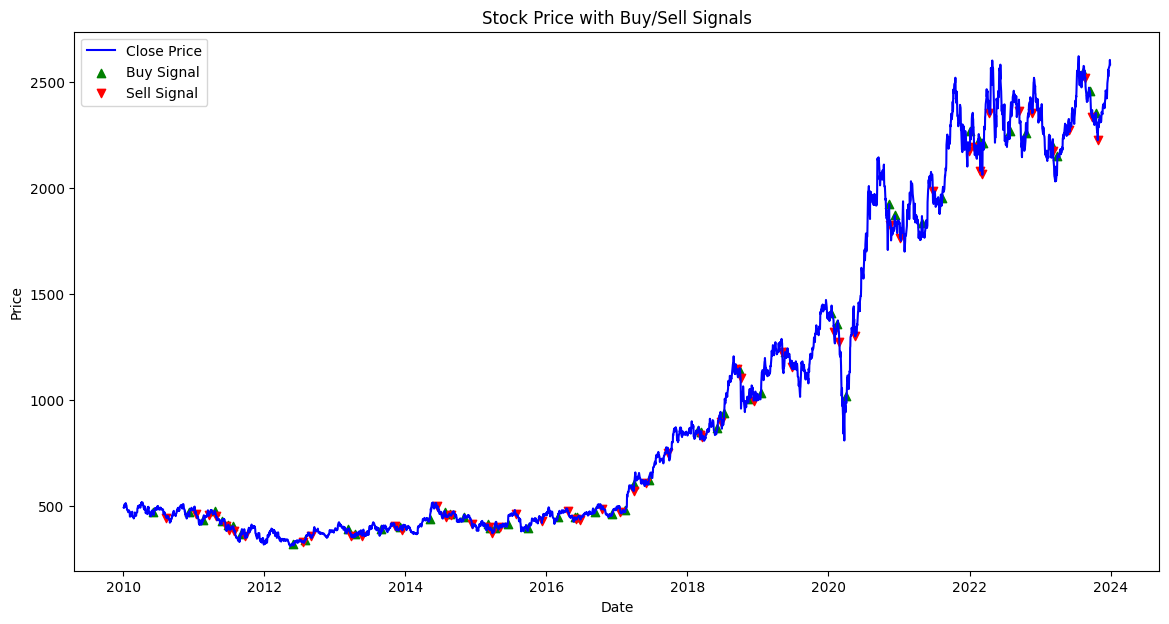

In [ ]:
# Define function to calculate Moving Average (MA)
def calculate_ma(df, n=20):
    """
    Function to calculate Moving Average (MA)
    """
    return df['Close'].rolling(window=n).mean()

# Define function to calculate Momentum Oscillator
def calculate_momentum_oscillator(df, n=14):
    """
    Function to calculate Momentum Oscillator
    """
    return df['Close'].diff(n)

# Define function to calculate Donchian Channels
def calculate_donchian_channels(df, n=14):
    """
    Function to calculate Donchian Channels
    """
    df['Upper_Donchian'] = df['High'].rolling(window=n).max()
    df['Lower_Donchian'] = df['Low'].rolling(window=n).min()
    return df['Upper_Donchian'], df['Lower_Donchian']

# Define function to calculate Accumulation/Distribution Line (A/D Line)
def calculate_ad_line(df):
    """
    Function to calculate Accumulation/Distribution Line (A/D Line)
    """
    ad_line = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']
    return ad_line.cumsum()

# Define function for trading strategy for Volume Confirmation
def apply_volume_confirmation_strategy(df):
    """
    Function to apply the Volume Confirmation trading strategy
    """
    ma = calculate_ma(df)
    df['Momentum_Oscillator'] = calculate_momentum_oscillator(df)
    upper_donchian, lower_donchian = calculate_donchian_channels(df)
    ad_line = calculate_ad_line(df)

    buy_conditions = (
        # Price crosses above the MA
        ((df['Close'] > ma) & (df['Close'].shift(1) <= ma.shift(1)) |
         (df['Close'].shift(1) > ma.shift(1)) & (df['Close'].shift(2) <= ma.shift(2))) &
        # Momentum Oscillator is rising
        ((df['Momentum_Oscillator'] > df['Momentum_Oscillator'].shift(1)) &
         (df['Momentum_Oscillator'].shift(1) > df['Momentum_Oscillator'].shift(2)) &
         (df['Momentum_Oscillator'].shift(2) > df['Momentum_Oscillator'].shift(3))) |
        # Price is above the upper Donchian Channel
        (df['Close'] > upper_donchian) & (df['Close'].shift(1) <= upper_donchian.shift(1)) &
        # A/D Line is increasing
        ((ad_line > ad_line.shift(1)) & (ad_line.shift(1) > ad_line.shift(2)) & (ad_line.shift(2) > ad_line.shift(3)))
    )

    sell_conditions = (
        # Price crosses below the MA
        ((df['Close'] < ma) & (df['Close'].shift(1) >= ma.shift(1)) |
         (df['Close'].shift(1) < ma.shift(1)) & (df['Close'].shift(2) >= ma.shift(2))) &
        # Momentum Oscillator is falling
        ((df['Momentum_Oscillator'] < df['Momentum_Oscillator'].shift(1)) &
         (df['Momentum_Oscillator'].shift(1) < df['Momentum_Oscillator'].shift(2)) &
         (df['Momentum_Oscillator'].shift(2) < df['Momentum_Oscillator'].shift(3))) |
        # Price is below the lower Donchian Channel
        (df['Close'] < lower_donchian) & (df['Close'].shift(1) >= lower_donchian.shift(1)) &
        # A/D Line is decreasing
        ((ad_line < ad_line.shift(1)) & (ad_line.shift(1) < ad_line.shift(2)) & (ad_line.shift(2) < ad_line.shift(3)))
    )

    df['Buy Signal'] = buy_conditions
    df['Sell Signal'] = sell_conditions

    return df

   # Define function to simulate trades
def simulate_trades_5(df):
    """
    Function to simulate trades based on strategy
    """
    trades = []
    position = None
    entry_price = None
    entry_date = None

    for index, row in df.iterrows():
     if row['Buy Signal']:
      if position != 'buy':
        position = 'buy'
        entry_price = row['Close']
        entry_date = index

     # Early exit for stop-loss
     if entry_price is not None and row['Close'] < entry_price * (1 - 0.05) and position == 'buy':
          exit_price = row['Close']
          exit_date = index
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None

     elif row['Sell Signal']:
      if position == 'buy':
          exit_date = index
          exit_price = row['Close']
          pnl = ((exit_price - entry_price) / entry_price * 100)
          trades.append({'Entry Date': entry_date, 'Exit Date': exit_date, 'Entry Price': entry_price, 'Exit Price': exit_price, 'PnL (%)': pnl})
          position = None

    trades_df = pd.DataFrame(trades)
    return trades_df

# Apply the strategy
df = apply_volume_confirmation_strategy(df)

# Simulate trades
trades_df = simulate_trades_5(df)

# Calculate performance metrics:
num_trades = len(trades_df)
average_return_per_trade = trades_df['PnL (%)'].mean()
win_rate = (trades_df['PnL (%)'] > 0).sum() / len(trades_df) * 100
risk_to_reward_ratio = abs(trades_df[trades_df['PnL (%)'] > 0]['PnL (%)'].mean() / trades_df[trades_df['PnL (%)'] < 0]['PnL (%)'].mean())
maximum_drawdown_ratio = trades_df['PnL (%)'].min()
sharpe_ratio = trades_df['PnL (%)'].mean() / trades_df['PnL (%)'].std()

# Print performance metrics
print("Number of Trades:", num_trades)
print("Average Return per Trade: {:.2f}%".format(average_return_per_trade))
print("Win Rate: {:.2f}%".format(win_rate))
print("Risk to Reward Ratio: {:.2f}".format(risk_to_reward_ratio))
print("Maximum Drawdown Ratio: {:.2f}%".format(maximum_drawdown_ratio))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

# Plot trades on a graph with stock price
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.scatter(trades_df['Entry Date'], trades_df['Entry Price'], marker='^', color='green', label='Buy Signal')
plt.scatter(trades_df['Exit Date'], trades_df['Exit Price'], marker='v', color='red', label='Sell Signal')
plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
trades_df

,Entry Date,Exit Date,Entry Price,Exit Price,PnL (%)
0,2010-06-04,2010-08-12,471.429962,444.639984,-5.682706
1,2010-12-07,2011-01-11,471.224213,463.452393,-1.649283
2,2011-02-16,2011-03-22,431.633606,457.006348,5.878305
3,2011-04-21,2011-04-27,475.727325,450.811737,-5.237368
4,2011-05-30,2011-06-16,429.210632,405.757996,-5.464132
5,2011-06-30,2011-07-05,410.763977,386.739868,-5.848641
6,2011-07-25,2011-07-28,403.609314,382.808258,-5.153760
7,2011-09-02,2011-09-22,368.224640,359.492767,-2.371344
8,2012-05-29,2012-07-20,320.862213,330.371277,2.963597
9,2012-07-31,2012-08-30,339.948914,358.144135,5.352340
